<a href="https://colab.research.google.com/github/mkorlyakova/test-face-recognition/blob/main/hypothesis_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2 as cv
import tarfile


In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import scipy.stats as st


Гипотеза 1: 
  metric lening


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence

In [ ]:
import seaborn as sns

вАЖЕН ЛИ СПОСОБ СЖАТИЯ?


In [ ]:
class CustomDataGenFace(Sequence):
  
  
  def __init__(self, 
               batch_size,
               input_size=(32, 32, 3),
               zipfile = '/gdrive/MyDrive/Face recognition/casia_faces.tar.gz',
               lab = 1,
               scale = [32,32],
               shuffle=True,
               ind1 = 1,
               ind2 = 10000):

    super().__init__()
    self.__batch_size = batch_size # 1
    self.input_size = input_size # 
    self.shuffle = shuffle
    self.scale = scale
    self.lab = lab # Lab
    self.zipfile = zipfile
    if zipfile.endswith("tar.gz"):
      self.tar = tarfile.open(self.zipfile, "r:gz")
    elif zipfile.endswith("tar"):
      self.tar = tarfile.open(self.zipfile, "r:")
    self.ll = self.tar.getmembers( )
    for k in self.ll[ind1:ind2]:
      self.tar.extract( k )
    self.tar.close()


  def __del__():
    
    #self.tar.close()
    super().__del__()
  
  def set_batch_size(self, batch_size):
        self.__batch_size = batch_size
        
 
  def get_batch_size(self):
        return self.__batch_size  


  def label_extract(self,index):
    try:
      #print(index)
      s = self.ll[index].name.split('/')
      if not os.path.exists(self.ll[index].name):
        #print(s)
        self.tar = tarfile.open(self.zipfile, "r:gz")
        self.tar.extract( self.ll[index] ) 
        self.tar.close()
      #print(self.ll[index])
      if len(s)>2:
      #if s[-2].find('person_')>=0:
        k = s[-2].find('person_')
        #print(k)
        if k>=0:
          label = s[-2][k+7:]
          #print(label)
          return int(label)
        else:
          return -1  
      else:
        return -1
    except FileNotFoundError:
      return -1      
  
  def image_extract(self,index):
    try:
      s = self.ll[index].name
      #print(s)
      img = cv.imread(s )
      if type(img) == type(cv.imread('')) :
        return np.zeros((1,32,32,3)), 0  
      else:
        img = cv.resize(img,(self.scale[1],self.scale[0]))
          
      if self.lab:
        img = cv.cvtColor(img, cv.COLOR_RGB2LAB)
      img = img.reshape(-1,self.scale[1],self.scale[0],3)
      return img, np.mean(img)
    except FileNotFoundError:
      return np.zeros((1,32,32,3)), 0
  
  #rotate image
  def rotation(self, image, angle):
    s = image.shape
    center=tuple(np.array([s[0],s[1]])/2)
    rot_mat = cv.getRotationMatrix2D(center,angle,1.0)
    new_image = cv.warpAffine(image, rot_mat, (s[1],s[0]))
    return 
    
  
    
  def on_epoch_end(self):
    pass
    
  def __getitem__(self, index):
    #print(index)
    image = []
    label = []
    try:
      i = 0
      ind = np.random.randint(0,100, (self.__batch_size*2))
      while (len(label)<self.__batch_size)&(i<self.__batch_size*2):
        
        k = self.label_extract(index+ind[i])
        if k>= 0:
          image_, m = self.image_extract(index+ind[i])
          if m>0:
            label_ = k
            #print(image_.shape, label_)
            image.append(image_[0,:,:,:])
            label.append(label_)
        i += 1
          
      return np.array(image),np.array(label)
    except FileNotFoundError:
      return np.zeros((1,32,32,3)),-1* np.ones((1, ))
  def __len__(self):
    
    return len(self.ll) // self.batch_size

Запуск генератора: 
  - читаем каталог примеров на диск
  - задаем размер пакета

In [ ]:
gen_d = CustomDataGenFace(100)

In [ ]:
gen_d.get_batch_size()

100

In [ ]:
#number уникальных пар
numb_L = []
for i in range(1,10000,100):
  I,L = gen_d[i]
  n = len(L) // 2
  dg = (L[:n] == L[n:n*2]).sum()
  print(dg)
  numb_L.append(dg)



In [ ]:
dL = numb_L.copy()
numb_L = np.array(numb_L)/gen_d.get_batch_size()*2

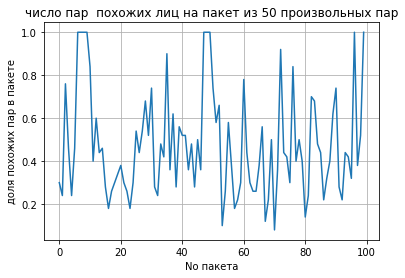

In [ ]:
plt.title('число пар  похожих лиц на пакет из 50 произвольных пар')
plt.plot(numb_L)
plt.xlabel('No пакета')
plt.ylabel('доля похожих пар в пакете')
plt.grid(True)
plt.show()

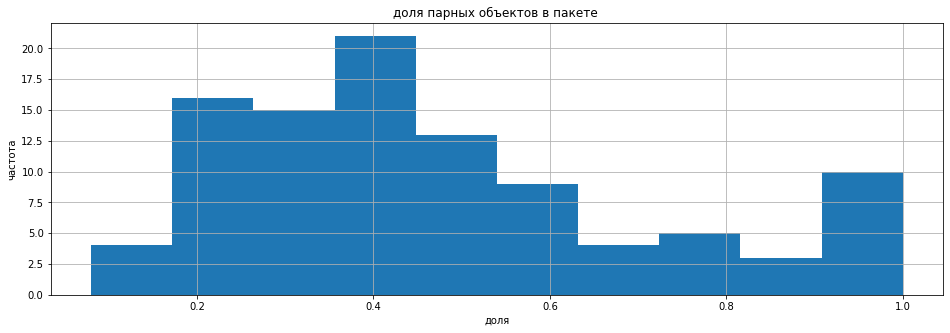

In [ ]:

plt.figure(figsize = (16,5))
plt.hist(numb_L,bins=10)
plt.grid(True)
plt.title('доля парных объектов в пакете ')
plt.xlabel('доля')
plt.ylabel('частота')
plt.show()


Схема сети для эмбединга: 

 - layer[0] сверточных блоков (С-С-MP)
 - layer[1] полносвязных блоков (FC-Drop)

In [ ]:
EMB_SIZE = 50

model_name = '/gdrive/MyDrive/Face recognition/siam_net.h5'

def net_creat(EMB_SIZE = 50, im_size = (32,32,3),X_size = 8, layer = [5,3], numb_neuro = 1):
  # поток I
  inp_x_im = tf.keras.layers.Input(shape=(im_size[0], im_size[1], im_size[2]))
  
  x1 = tf.keras.layers.Conv2D(32*numb_neuro, (3, 3), padding='same', activation='relu')(inp_x_im)
  for k in range(layer[0]):
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
    
  x1 = tf.keras.layers.Flatten()(x1)
  # поток Х 
  x = tf.keras.layers.Dense(256*EMB_SIZE, activation='relu')(x1)
  x = tf.keras.layers.Dropout(0.5)(x)
  for k in range(layer[1]):
    x = tf.keras.layers.Dense(EMB_SIZE*numb_neuro, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)

  return tf.keras.models.Model( inputs =inp_x_im, outputs = x)  

In [ ]:
model = net_creat(EMB_SIZE = EMB_SIZE, im_size = (32,32,3),X_size=8, layer = [4,0])

In [ ]:
im_size=(32,32,3)

In [ ]:
model.load_weights(model_name)

In [ ]:
NUM_EPOCHS =5 # число эпох 
NUM_BATCH = 40 # число пакетов

LEARNING_RATE = 0.001 # скорость обучения

# оптимизатор
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# зазор
MARGIN = 100.0

In [ ]:

# https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
# Функция потерь
def contastive_loss(embs, labels):
  # print(embs,labels)
  bs = embs.shape[0]
  embs1 = embs[:bs//2, :]
  embs2 = embs[bs//2:, :]
  
  labels1 = labels[:bs//2]
  labels2 = labels[bs//2:]
  #print(labels1,labels2)
  d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
  d =  tf.sqrt(d2)
  z = tf.cast(labels1 == labels2, tf.float32)
    
    
  return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [ ]:
# обучение сиамской сети

def train_step(model, I,L,  hist):
  '''
  Реализация одного шага обучения (для одной картинки по всем ее рамкам )
  model - модель, 
  I,X,L - признаки и метки, 
  ind - индексы для пакета
  '''

  #print(ind_iter)
  # Forward
  with tf.GradientTape() as tape:
        
        embs = model( I)
        #print(embs.numpy())
       
        loss_value = contastive_loss(embs, L)
       
        
  # Backward
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables))
  hist.append(loss_value.numpy())
  if loss_value.numpy()!=0:
            print( loss_value.numpy())
  return model, hist   

In [ ]:
image_shape = []
numb_bound = []
image_shape = []
numb_bound = []
hist = []

In [ ]:
# применим обучение модели для следующих эпох
for ch in range(NUM_EPOCHS):
  for i in range(1,1000,100):
    I,L = gen_d[i]
    
    model, hist = train_step(model, I,L, hist)


casia_faces/person_3171/9e34391e-1416-44dd-8f3f-7cdcc080a388.jpg
casia_faces/person_3171/00fdd843-1dbf-4b2b-a744-ffd33543e05b.jpg
casia_faces/person_6656/6175bd00-e286-4417-bc65-128a4530321b.jpg
casia_faces/person_6656/e85aacc4-5f14-458c-a41e-bb950dc80f45.jpg
casia_faces/person_1694/82496632-da49-4c0b-92c8-99dc848e7dfa.jpg
casia_faces/person_7342/c98ee267-3e6a-4161-b727-00e35939e94b.jpg
casia_faces/person_3171/be054e79-6fd2-434a-8168-f9c088a9998f.jpg
casia_faces/person_1694/5b620556-7b11-475f-a577-21795f7c7be9.jpg
casia_faces/person_7342/38e649fd-f69c-4559-b58a-415c9b17004e.jpg
casia_faces/person_1694/45297f75-dcfb-4374-a81e-4fb8df380fd4.jpg
casia_faces/person_1694/b809c09e-c75d-4913-9ec4-70b7e21ed722.jpg
casia_faces/person_3171/c9a0fc89-3940-4939-8af3-b7ba69507c28.jpg
casia_faces/person_1694/4d9627d2-cd3e-48fe-b353-e32cc23828a9.jpg
casia_faces/person_1694/293ac8e8-588b-4231-bd09-aa7289cab541.jpg
casia_faces/person_1694/705947b3-92f3-4a1e-b2c2-76841583fe77.jpg
casia_faces/person_7342/8

In [ ]:
# вычисление метрики для вложеня (Euqlid)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

# вычисление пар по меткам
#for i in range(len(L)-1):
#  for j in range(i+1,len(L)): 
#    if (lab[j] != -1) & (lab[i] != -1):
#      print(lab[i],' <-> : ',lab[j], ' : ', diff(emb[i], emb[j]))

In [ ]:
gen_d.set_batch_size(100)

In [ ]:
# метрики по эмбедингу (вложению)
def my_embed_metric(X,L):
  net_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  label_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      net_dist[i,j] = diff( X[i,:],X[j,:])
      net_dist[j,i] =  net_dist[i,j]
      label_dist[i,j] = int(L[i] == L[j])
      label_dist[j,i] =  label_dist[i,j]

      

      
  return net_dist, label_dist# 

def image_clast_net(image_name='',  model=None,  ind=13200,  verbose=1, gen_d  = None):
  '''
  полный цикл для кластер- анализа
  вход:
  image_name - имя картинки, json_arr - имя аннотации, verbose = 0, w = 15
  
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны  
   
  гиперпараметры алгоритма

  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  L - разметка по кластеранализу
  iou,n_dist,m_dist - метрики 
  box_bound_clear - рамки
  
  ''' 

  I = []
  L = []
  
  
  # картинке ставим в соответствие аннотацию
  batch_size = gen_d.get_batch_size()*2
  
 
  if 1:
    # строим признаки 
    I1,L_1 = gen_d[ind]
    I2,L_2 = gen_d[ind+ np.random.randint(5000)]

    I = np.vstack((I1,I2))
    L = np.hstack( (L_1,L_2))

    #смешать данные

    ind1 = np.arange(len(L_1)).tolist()
    
    ind2 = (np.arange(len(L_2)) + (batch_size // 2)).tolist()

    ind  = ind1[::2]+ind2[::2]+ind1[1::2]+ind2[1::2]

    
    I = I[ind,:,:,:]
    L = L[ind]
    print(I.shape,L.shape)
    batch_size = len(L)


    # строим метрики
    if 1:
      
      X_emb = model.predict(I)
      n_emb,l_dist = my_embed_metric(X_emb,L)

      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,3,1)
        plt.imshow(n_emb)
        plt.title('Эмбединг')
        plt.subplot(1,3,2)
        plt.imshow(n_emb * l_dist)
        plt.title('Эмбединг 1')
        plt.subplot(1,3,3)
        plt.imshow(n_emb * (-l_dist+1))
        plt.title('Эмбединг 0')  
        plt.show()
      # анализ  
      Dist1 = []
      Dist0 = []
      for i in range(batch_size):
        for j in range(i+1,batch_size-1):
          if l_dist[i,j] :
            Dist1.append(n_emb[i,j])
          else:
            Dist0.append(n_emb[i,j])  
      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,2,1)
        plt.hist(Dist0,alpha = 0.5,bins = 100, label = 'labeli!=labelj : 0')
        plt.hist(Dist1,alpha = 0.5,bins = 100, label = 'labeli!=labelj : 1')
        plt.legend()
      
        plt.grid(True)
        plt.title('распределение рaсстояний по типам пар')
        plt.subplot(1,2,2)
        sns.kdeplot(Dist0,)
        sns.kdeplot(Dist1)
        plt.grid(True)
        plt.legend()
        plt.title('распределение рaсстояний по типам пар')
        plt.show()
      m0 = np.mean(Dist0)
      m1 = np.mean(Dist1)
      print('средняя дистанция по 0:',m0)
      print('средняя дистанция по 1:',m1)
      d0 = np.std(Dist0)
      d1 = np.std(Dist1)

      L1 = len(Dist1)
      L0 = len(Dist0)
      if L1>L0:
        L_d01 = L0
      else:
        L_d01 = L1  
      print('std по 0:',d0)
      print('std по 1:',d1)
      conf_int0 = st.t.interval(0.99, len(Dist0)-1, loc=np.mean(Dist0), scale=st.sem(Dist0))
      conf_int1 = st.t.interval(0.99, len(Dist1)-1, loc=np.mean(Dist1), scale=st.sem(Dist1))
      print('доверит.интервал 0',conf_int0)
      print('доверит.интервал 1',conf_int1)
      print('интервал 3 sigms 0',[m0-d0*3,m0+d0*3])
      print('интервал 3 sigma 1',[m1-d1*3,m1+d1*3])
      if verbose:
        plt.plot([0,0,0],[conf_int0[0],m0,conf_int0[1]],'-og', label='0')
        plt.plot([1,1,1],[conf_int1[0],m1,conf_int1[1]], '-ok',label='1')
        plt.plot([0,0,0],[m0-d0*3,m0,m0+d0*3],'--xb', label='3 sigma 0')
        plt.plot([1,1,1],[m1-d1*3,m1,m1+d1*3], '--xr',label='3 sigma 1')
        plt.legend()
        plt.title('доверит.интервал по типам пар и 3sig')
        plt.show()
      wc = wilcoxon(Dist1[:L_d01],Dist0[:L_d01])[1]
      mu = mannwhitneyu(Dist1,Dist0)[1]
      print('тест Мана-Уитни p_value:', mu)
      print('тест Вилкокса p_value:', wc)
      stat_rez = [m0,m1,d0,d1,conf_int0[0],conf_int0[1],conf_int1[0],conf_int1[1],mu,wc,m0-d0*3,m0+d0*3,m1-d1*3,m1+d1*3]

      
    else:
      print('нет фичей')
  else:
    print('не найден файл')
  return I, L, n_emb, l_dist, stat_rez

(200, 32, 32, 3) (200,)


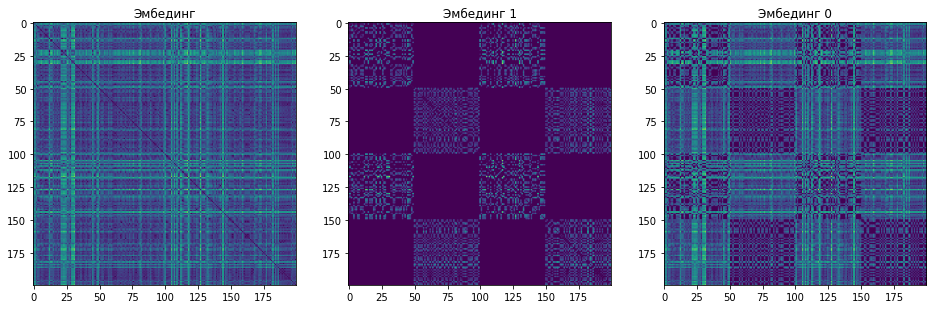

No handles with labels found to put in legend.


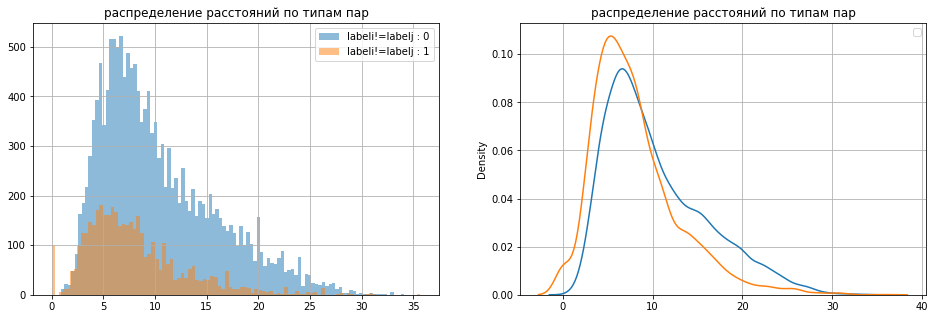

средняя дистанция по 0: 10.39095357672912
средняя дистанция по 1: 8.011242852197006
std по 0: 5.616939396715458
std по 1: 4.8337155332658455
доверит.интервал 0 (10.274637157632755, 10.507269995825483)
доверит.интервал 1 (7.819559692299762, 8.202926012094249)
интервал 3 sigms 0 [-6.459864613417254, 27.241771766875495]
интервал 3 sigma 1 [-6.489903747600531, 22.512389451994544]


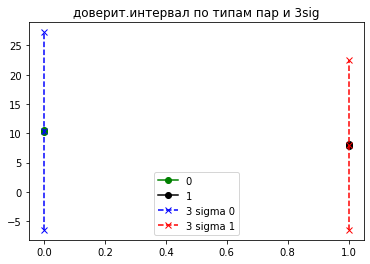

тест Мана-Уитни p_value: 9.616922632048303e-147
тест Вилкокса p_value: 1.3273758239596089e-131


In [ ]:
I, L, n_emb, l_dist,stat_s = image_clast_net(image_name='',  model=model,  ind=12100,  verbose=1,gen_d = gen_d)

In [ ]:
model.save_weights(model_name)

Есть перспектива. Работаем на поиск модели:

  - гиперпараметры: 
        - размер эмбединга
        - размер сети
        - лосс : перейти на cos 
        - размер пакета
        - параметры оптимизитора

  - доработать генератор:   
        - строить более сложный пакет - на один шаг обучения брать 2 точки из генератора ( перенести раскрытие архива в инициализацию - кусками по тексту архива )

  - написать метрику для финальной оценки 
  - уточнить тип метрики - завтра утром  

Дизайн эксперимента:
  - размер эмбединга [16,32,64,128,256,512] (размер входа 32х32х3 = 3072 - брать вложение сильно больше не вижу смысла (пока) )
        - размер сети (уложить размеры до 1М параметров - т.к. вход маленький) 

In [ ]:
# Эксперимент

rez = pd.DataFrame(data = np.zeros((60,14)), columns = ['Embed_size','k','m0','m1','d0','d1','conf_int0[0]','conf_int0[1]','conf_int1[0]','conf_int1[1]','mu','wc','m0 -3s0','m0+3s0','m1 -3s1','m1+3s1']) 


In [ ]:
rez.to_csv('/gdrive/MyDrive/Face recognition/rez.csv')

In [ ]:


epoch = 5
m = 0
for EMB_SIZE in  [16,32,64,128,256,512]:
  for k in [1,2]:
    for n in range(5):
      model = net_creat(EMB_SIZE = EMB_SIZE, im_size = (32,32,3),X_size=8, layer = [4,0], numb_neuro=k)


      image_shape = []

      image_shape = []
      numb_bound = []
      hist = []
      for ch in range(NUM_EPOCHS):
        for i in range(1,1000,100):
          ind_i = np.random.randint(0,10000)
          I,L = gen_d[ind_i]
    
          model, hist = train_step(model, I,L, hist)

      model.save_weights('/gdrive/MyDrive/Face recognition/'+'siam_net_'+str(EMB_SIZE)+'_'+str(k)+'_'+str(n) +'_.h5')
      I, L, n_emb, l_dist,stats_rez = image_clast_net(image_name='',  model=model,  ind=12100,  verbose=1, gen_d = gen_d)
      rez.iloc[m,:] =[EMB_SIZE,k]+ stats_rez
      m += 1
      rez.to_csv('/gdrive/MyDrive/Face recognition/rez.csv')

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/Face recognition/rez_19_11.csv', index_col=[0])

df.head()

,Embed_size,k,m0,m1,d0,d1,conf_int0[0],conf_int0[1],conf_int1[0],conf_int1[1],mu,wc
0,16.0,1.0,45.131122,39.086577,30.028160,30.028160,44.522919,45.739324,37.856989,40.316164,2.735098e-30,3.889255e-24
1,16.0,1.0,7.456456,6.681604,4.393203,4.393203,7.357783,7.555130,6.564056,6.799152,2.293222e-21,8.106605e-13
2,16.0,1.0,2.551580,2.705301,1.407271,1.407271,2.519790,2.583370,2.652143,2.758459,2.629399e-03,3.183180e-06
3,16.0,1.0,18.119575,17.338166,10.324973,10.324973,17.884569,18.354581,17.023726,17.652605,1.113500e-06,1.861123e-05
4,16.0,1.0,36.395775,30.671471,20.563510,20.563510,35.980976,36.810575,29.768764,31.574178,6.219860e-54,1.528661e-15


In [ ]:
df.groupby(['Embed_size','k']).mean()

m0          m1  ...            mu            wc
Embed_size k                            ...                            
0.0        0.0    0.000000    0.000000  ...  0.000000e+00  0.000000e+00
16.0       1.0   21.930902   19.296624  ...  5.261026e-04  4.358882e-06
           2.0   33.167488   26.447241  ...  1.513197e-23  4.279158e-12
32.0       1.0   14.210585   12.709474  ...  2.828184e-05  1.848312e-01
           2.0   11.682303   10.613095  ...  6.218072e-03  6.598413e-02
64.0       1.0    9.768691    8.970298  ...  8.047139e-03  8.806262e-06
           2.0   11.435014    9.790663  ...  1.377459e-07  1.768489e-01
128.0      1.0   23.527325   21.206637  ...  4.276630e-05  1.672111e-01
           2.0   67.530428   55.776834  ...  2.657793e-17  1.753169e-07
256.0      1.0   71.103094   66.347425  ...  6.903858e-04  1.322010e-01
           2.0  235.509934  186.819906  ...  1.722562e-11  1.861509e-01
512.0      1.0   57.207401   47.703292  ...  1.717374e-24  1.207942e-14

[12 rows x 10 columns]

In [ ]:
# https://www.sigma-is.ru/files/article/art_ab_nic_5_2015.pdf
# https://habr.com/ru/post/317798/

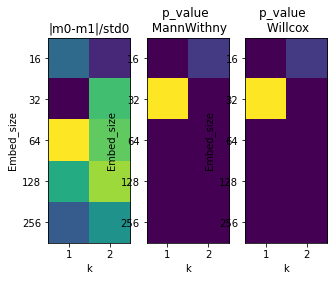

In [ ]:
im1 = np.abs((df.m0-df.m1)/df.d0).values[1:11].reshape(5,2)
im2 = df.mu.values[1:11].reshape(5,2)
im2 = df.wc.values[1:11].reshape(5,2)
plt.figure(figsize=(5,14))
plt.subplot(1,3,1)
plt.imshow(im1)
plt.xticks(np.arange(2), ['1','2'])
plt.yticks(np.arange(5), ['16','32','64','128','256'])
plt.xlabel('k')
plt.ylabel('Embed_size')
plt.title('|m0-m1|/std0')
plt.subplot(1,3,2)
plt.imshow(im2)
plt.xticks(np.arange(2), ['1','2'])
plt.yticks(np.arange(5), ['16','32','64','128','256'])
plt.xlabel('k')
plt.ylabel('Embed_size')
plt.title('p_value \n MannWithny')
plt.subplot(1,3,3)
plt.imshow(im2)
plt.xticks( np.arange(2), ['1','2'])
plt.yticks(np.arange(5), ['16','32','64','128','256'])
plt.xlabel('k')
plt.ylabel('Embed_size')
plt.title('p_value  \n Willcox')
plt.show()


Резюме гипотезы 2: 
  - лучшие значения по отношению расстояние между m1, m0 к отношению с рассеиванием sigma0 : эмбединг = 64, k = 1
  - по тестам все варианты  больше или равные эмбединг = 64 - рабочие.

  Необходимо построить оценку сетей с метриками на отложенной выборке, пока не lfw.

  1) Построить механизм предсказания для отложенной выборки

  2) Механизм анализа модели(метрики https://habr.com/ru/post/317798/):

    - Accuracy = (TP+TN)/(FP+FN+TP+TN)
    - ERR 
    - FAR
    - FFR


In [ ]:
# Предсказание

def L2_metric(X1,X2):
  return np.sum((X1-X2) ** 2) ** 0.5
def cos_metric(X1,X2):
  return np.dot(X1.T/(np.sum(X1*X1))**0.5,X2/(np.sum(X2*X2))**0.5) 

def predict(I1,I2,model):
  I = np.array([I1[:,:,:],I2[:,:,:]])
  X_emb = model.predict(I)
  n_emb = L2_metric(X_emb[0,:],X_emb[1,:])
  return n_emb


def pred_batch(ind, model,gen_d):
  I,L = gen_d[ind]
  n_emb = []
  for i in range(len(L)//2):
    p = predict(I[i,:,:,:],I[len(L)//2+i,:,:,:],model)
    #print(p,I[i,:,:,:].mean(),I[len(L)//2+i,:,:,:].mean())
    n_emb.append([p, int(L[i]==L[len(L)//2+i])])  
  return n_emb



In [ ]:
r_embed  = pred_batch(12100, model,gen_d)



24.742969477696462 110.35481770833333 123.46451822916667
5.452909011716909 122.39908854166667 108.41861979166667
14.903524281549723 102.9970703125 111.8427734375
21.296983188234005 122.462890625 130.85286458333334
17.242215818961792 115.64192708333333 113.35970052083333
2.1209195172598716 113.26790364583333 116.87141927083333
13.485736800260431 118.05045572916667 123.52083333333333
13.182300283770067 103.14876302083333 122.462890625
16.697801018034998 128.41471354166666 125.61979166666667
11.25428724190218 109.36165364583333 119.88118489583333
6.226498784178393 115.41438802083333 121.41764322916667
3.6086961512417894 116.87141927083333 121.41764322916667
30.10851650469151 112.09733072916667 113.35970052083333
6.369849124960171 117.099609375 119.0234375
5.759539113679319 121.12727864583333 121.76953125
28.379834002815162 130.01595052083334 121.41764322916667
15.778115986764607 99.56477864583333 128.41471354166666
17.054785021766527 130.69563802083334 102.501953125
20.991995602956173 121

In [ ]:
r_embed = np.array(r_embed)

No handles with labels found to put in legend.


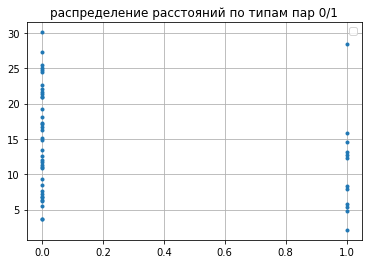

In [ ]:
plt.plot(r_embed[:,1],r_embed[:,0],'.')
plt.grid(True)
plt.legend()
plt.title('распределение рaсстояний по типам пар 0/1')
plt.show()

In [ ]:
# https://habr.com/ru/post/317798/

def calc_metrics(targets_scores, imposter_scores):
    min_score = np.minimum(np.min(targets_scores), np.min(imposter_scores))
    max_score = np.maximum(np.max(targets_scores), np.max(imposter_scores))
    print(min_score,max_score)
    n_tars = len(targets_scores)
    n_imps = len(imposter_scores)

    N = 100

    fars = np.zeros((N,))
    frrs = np.zeros((N,))
    dists = np.zeros((N,))

    mink = float('inf')
    eer = 0

    for i, dist in enumerate(np.linspace(min_score, max_score, N)):
        far = len(np.where(imposter_scores > dist)[0]) / n_imps
        frr = len(np.where(targets_scores < dist)[0]) / n_tars
        fars[i] = far
        frrs[i] = frr
        dists[i] = dist

        k = np.abs(far - frr)

        if k < mink:
            mink = k
            eer = (far + frr) / 2

    return eer, fars, frrs, dists

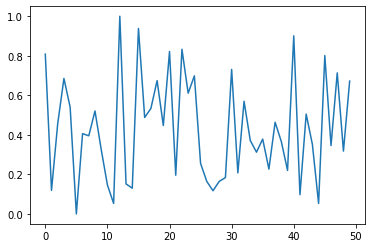

In [ ]:
plt.plot((r_embed[:,0] - r_embed[:,0].min())/(r_embed[:,0].max() - r_embed[:,0].min()))

In [ ]:
eer,far,frr,dist_ = calc_metrics(r_embed[:,1],(r_embed[:,0] - r_embed[:,0].min())/(r_embed[:,0].max() - r_embed[:,0].min()))

0.0 1.0


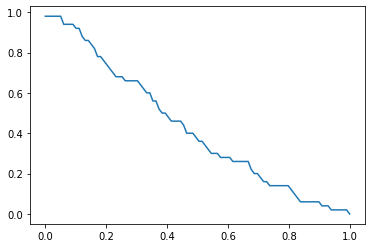

In [ ]:
plt.plot(dist_ ,far)

In [ ]:
eer

0.76